# 02 AE Model Development

### This notebook implements the following

1. Make Train and validation subsets
2. Load in train and validation subsets
3. Prepare datasets (scale and reshape)
4. Define Model Architecture
5. Model Development (train, visualize loss, save weights)
6. Reload in models
7. Visualize Latent Representation

### Notes

- Ran into a number of memory issues
- used very small subsets of val_specs.npy for training and validation
- Training and Validation loss are almost identical
- We should try subsets in the training_specs as well 
- We can consider splitting this workflow into multiple notebooks
- Need to decide which experiments each of us are running
- Maybe we should each have a folder in G51/models?

### TODO

1. Create a "Gold" Test set (ie the list song ID's (and thier communities #'s).
2. Remove the "Gold" song id's from training validation subsets
3. Save the Gold Test Spectrograms, and load them in as "Mini-batch" to obtain their latent representations
4. Save out these latent representations and load them into the clustering and comparative analysis notebook

In [1]:
import tensorflow as tf
import numpy as np
from numpy import save
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle
from IPython.display import Image

In [2]:
tf.keras.backend.clear_session()

# Step 1: Make Train and Validation Subsets

### Note * Due to memory issues when training, save out the subsets, restart kernel and load (step 2)

In [ ]:
val_raw = np.load('/datasets/home/21/321/ee228sp20ta1/G51/spectrograms/val_specs.npy')
from sys import getsizeof
X_valid = val_raw[:1915]

X_train = val_raw[1915:5000]

base_path = '/datasets/home/21/321/ee228sp20ta1/G51/spectrograms/'
save(base_path+'test_X_train.npy',X_train)
save(base_path+'test_X_valid.npy',X_valid)


In [3]:
test = np.load('/datasets/home/21/321/ee228sp20ta1/G51/val_specs')

IsADirectoryError: [Errno 21] Is a directory: '/datasets/home/21/321/ee228sp20ta1/G51/val_specs'

# Step 2: Load in train and validation subsets

In [3]:
X_train = np.load('/datasets/home/21/321/ee228sp20ta1/G51/spectrograms/test_X_train.npy')
X_valid = np.load('/datasets/home/21/321/ee228sp20ta1/G51/spectrograms/test_X_valid.npy')

# Step 3: Scale and Reshape data

1. Reduces data to 2D
2. Apply scaling function
3. Reshape for model input

In [4]:
#
x_train = X_train[:,:,:216].copy()
x_train = x_train.reshape((3085*96,216))

x_valid = X_valid[:,:,:216].copy()
x_valid = x_valid.reshape((1915*96,216))


print(x_train.shape)
print(x_valid.shape)

scaler = MinMaxScaler().fit(x_train) 
scaled_train = scaler.transform(x_train)
scaled_valid = scaler.transform(x_valid)

s_train_reshaped = scaled_train.reshape(3085,96,216,1)
s_valid_reshaped = scaled_valid.reshape(1915,96,216,1)

(296160, 216)
(183840, 216)


### Optional, Visualize Spectrograms

1. Compare scaled and unscaled spectrograms

In [ ]:
# plt.figure(figsize=(15,7))
# plt.subplot(211)
# plt.imshow(s_valid_reshaped[0,::-1], origin='lower', cmap='inferno')
# plt.xlabel('Time')
# plt.ylabel('Mel Filter Number')
# plt.title('Normal Data Melspectrogram (64 Mels)') 

## Step 4: Define Model Architecture

In [5]:
def AE_01():
    
    #### Encoder ####
    model = models.Sequential()
    model.add(keras.Input(shape=(96,216,1)))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(45, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    #### Decoder ####
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(45, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(1,(3, 3), padding='same'))
    
    return model



In [ ]:
# print(AE.summary())

## Step 5: Model Development

### Note: Need to use small batch size to avoid memory issues

1. Initialize Model
2. Initialize Loss and Optimizer, hyperparameters
3. Fit
4. Predict
5. Save Model
6. Visualize Loss

In [7]:
models_path = '/datasets/home/21/321/ee228sp20ta1/G51/models/'

In [ ]:
AE = AE_01()

AE.compile(loss='mse', optimizer='adam')

history = AE.fit(s_train_reshaped, s_train_reshaped, validation_data=(s_valid_reshaped, s_valid_reshaped), epochs=50, batch_size=15, shuffle=True)

# decoded_data = AE.predict(s_valid_reshaped)

In [ ]:


# Define model name convention
# Maybe we should use more folders to keep directory clean?
AE.save_weights(models_path+'ae_01')

In [ ]:
#Plot train/validation loss vs epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Step 6: Load in Model

### Note: When finished training a model, save out, restart kernel, and load weights to avoid memory issues

In [8]:
AE = AE_01()

# Restore the weights
AE.load_weights(models_path+'ae_01')

## Step 7:  Visualize Encoder - Latent Space - Decoder 

### Note: Need to create a mini-batch to avoid memory issues
### Note: Dimensionality of latent space will need to be adjusted

In [12]:
mini_batch = s_valid_reshaped[:100]
#print(mini_batch.shape)

decoded_data = AE.predict(s_valid_reshaped)

In [10]:
#Obtain encoder representation of data
get_hl = K.function([AE.layers[0].input], [AE.layers[6].output])
AE_h1 = get_hl([mini_batch])[0]

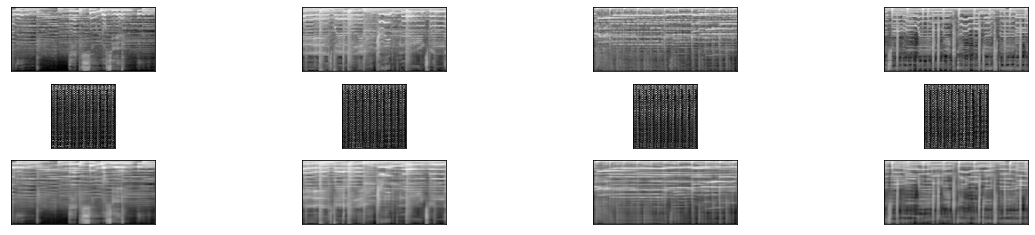

In [16]:
#Plot samples of input images, their hidden layer representations, and their reconstructions
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(s_valid_reshaped[i].reshape(96, 216))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(AE_h1[i].reshape(72, 72)) # Will have to reshape if you change the latent dimensionality
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_data[i].reshape(96, 216))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()